Total Number of Samples: 454684
Unique Artworks: 80031
Average Caption Length: 15.69 words


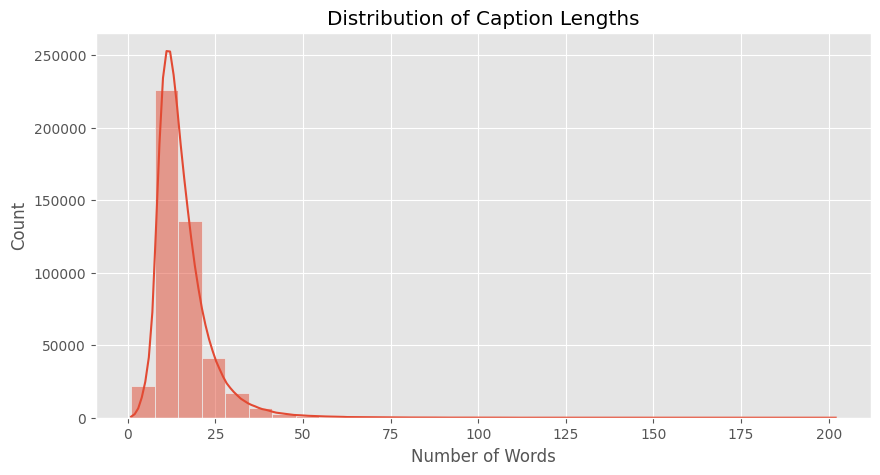

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.util import ngrams
import os
from PIL import Image

# Setup
# nltk.download('punkt') # Uncomment if not downloaded
plt.style.use('ggplot')

# Load the dataset
# Assuming columns: 'art_style', 'painting', 'emotion', 'utterance' (standard ArtEmis format)
# Adjust column names if your CSV is different.
df = pd.read_csv("captions.csv") 

# 1. Basic Counts
print(f"Total Number of Samples: {len(df)}")
print(f"Unique Artworks: {df['painting'].nunique()}")

# 2. Caption Length Analysis
df['caption_length'] = df['utterance'].apply(lambda x: len(str(x).split()))
avg_len = df['caption_length'].mean()
print(f"Average Caption Length: {avg_len:.2f} words")

# Plot Caption Length Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['caption_length'], bins=30, kde=True)
plt.title("Distribution of Caption Lengths")
plt.xlabel("Number of Words")
plt.show()

Vocabulary Size (unique words): 99870


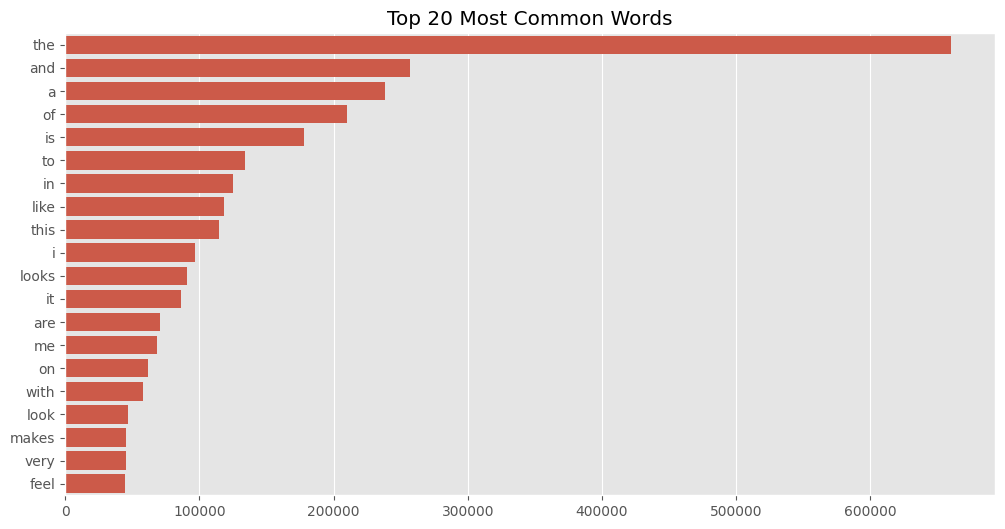

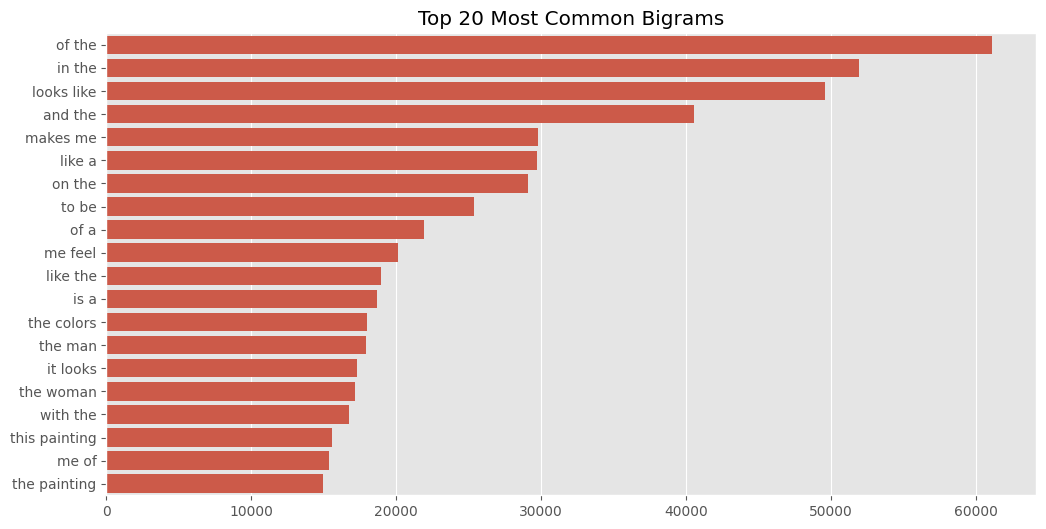

In [2]:
# Helper function to get top N-grams
def get_top_ngrams(corpus, n=1, top_k=20):
    vec = []
    for text in corpus:
        tokens = str(text).lower().split()
        # Create n-grams
        if len(tokens) >= n:
            vec.extend(list(ngrams(tokens, n)))
            
    # Count frequency
    counter = Counter(vec)
    return counter.most_common(top_k)

# 1. Vocabulary Size
all_words = [word for caption in df['utterance'] for word in str(caption).lower().split()]
vocab_size = len(set(all_words))
print(f"Vocabulary Size (unique words): {vocab_size}")

# 2. Top 20 Words (Unigrams)
top_words = get_top_ngrams(df['utterance'], n=1, top_k=20)
words, counts = zip(*top_words)
words = [w[0] for w in words] # Extract word from tuple

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title("Top 20 Most Common Words")
plt.show()

# 3. Top 20 Bigrams (Two-word combinations)
top_bigrams = get_top_ngrams(df['utterance'], n=2, top_k=20)
bigrams, counts = zip(*top_bigrams)
bigrams = [" ".join(b) for b in bigrams]

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(bigrams))
plt.title("Top 20 Most Common Bigrams")
plt.show()

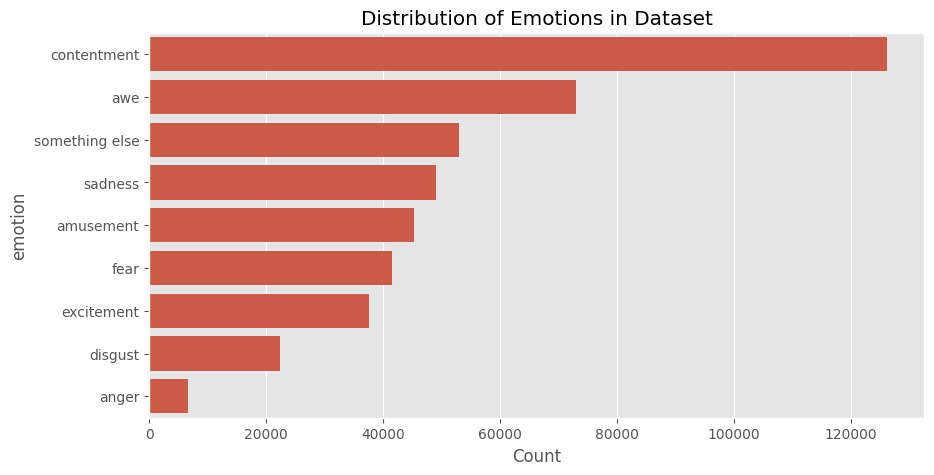

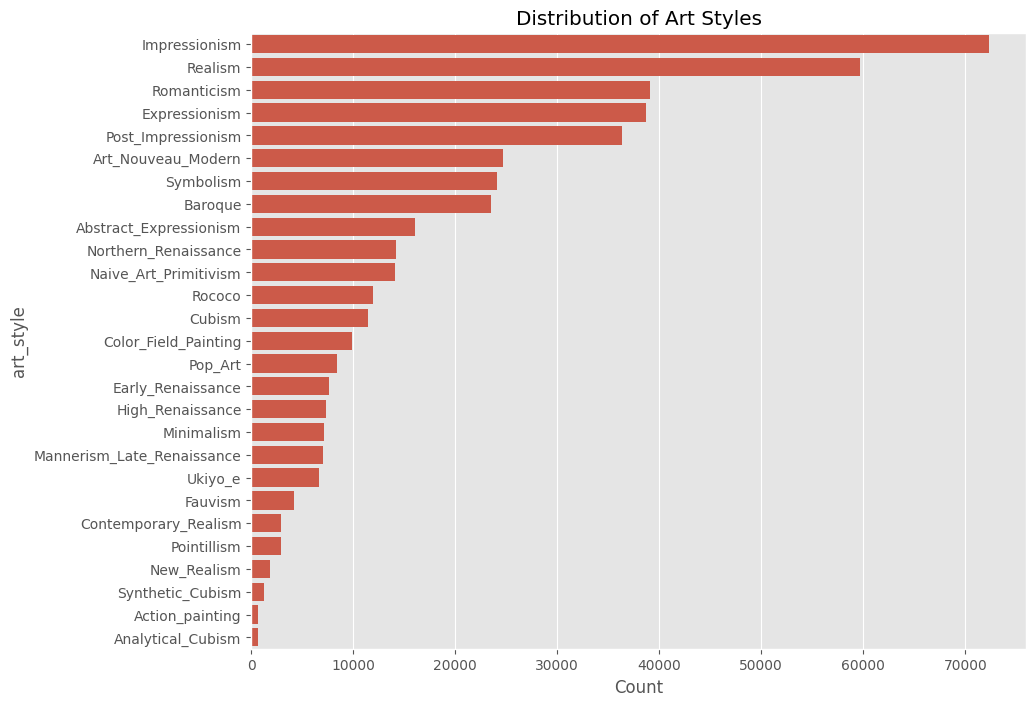

In [3]:
# 1. Emotion Distribution
plt.figure(figsize=(10, 5))
sns.countplot(y='emotion', data=df, order=df['emotion'].value_counts().index)
plt.title("Distribution of Emotions in Dataset")
plt.xlabel("Count")
plt.show()

# 2. Art Style Distribution
# This checks if your subset is biased towards one style (e.g., Impressionism)
plt.figure(figsize=(10, 8))
sns.countplot(y='art_style', data=df, order=df['art_style'].value_counts().index)
plt.title("Distribution of Art Styles")
plt.xlabel("Count")
plt.show()


Sample 1: The faces look misshapen and the proportions are off.
Sample 2: the scene is busy with people who are engaged with one another and their activities
Sample 3: I really just do not like seeing a lot of people, especially when they all are blank faced and nondescript. It gives me the bad kind of existential feelings.


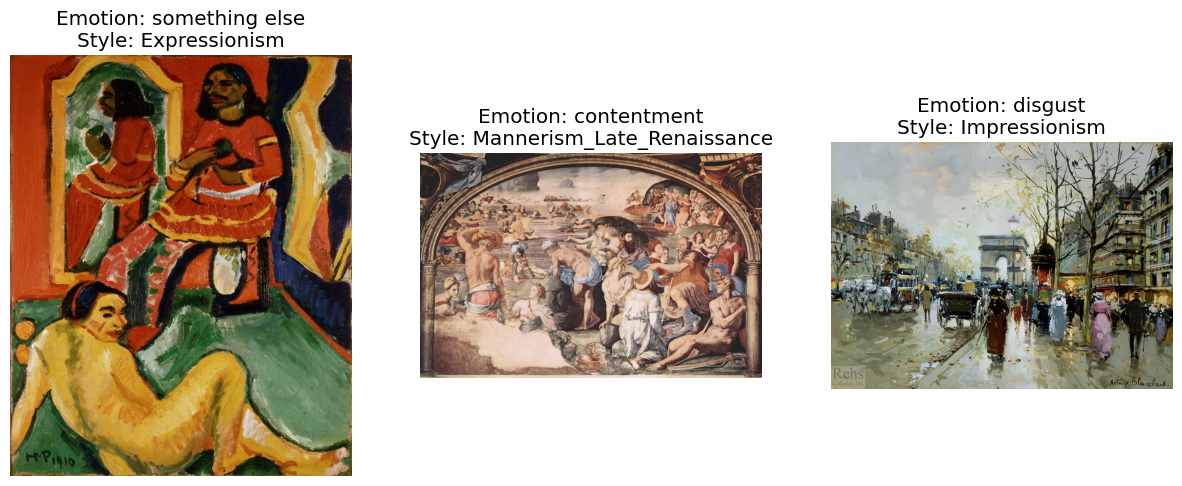

In [3]:
import random

def visualize_samples(df, image_folder, num_samples=3):
    plt.figure(figsize=(15, 10))
    
    # Sample random rows
    samples = df.sample(num_samples)
    
    for i, (_, row) in enumerate(samples.iterrows()):
        img_name = row['painting'] # Or 'image_file' depending on your CSV
        caption = row['utterance']
        emotion = row['emotion']
        style = row['art_style']
        
        # Load image
        img_path = os.path.join(image_folder, style, img_name + ".jpg") 
        # Note: ArtEmis folder structure is usually style/painting.jpg. 
        # Adjust path logic if your images are all in one folder.
        
        try:
            image = Image.open(img_path)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(image)
            plt.title(f"Emotion: {emotion}\nStyle: {style}")
            plt.axis("off")
            
            # Print caption below
            print(f"Sample {i+1}: {caption}")
        except FileNotFoundError:
            print(f"Could not find image: {img_path}")

    plt.show()

# Run visualization
# Replace "wikiart/" with the actual path to your images folder
visualize_samples(df, image_folder="wikiart/", num_samples=3)

# 3. Preprocessing

Initializing Vocabulary and DataLoader...
Dataset too large (454684). Subsetting to 6000 samples for efficiency.
✅ Preprocessing Complete.
Vocabulary Size: 1645 words
Number of Batches: 188


/Users/ape/Documents/Ashoka/Monsoon 2025/Introduction to Machine Learning/Assignments/Assignment 3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Batch Verification ---
Image Batch Shape: torch.Size([32, 3, 224, 224])
Caption Batch Shape: torch.Size([32, 46])
Emotion Batch Shape: torch.Size([32])


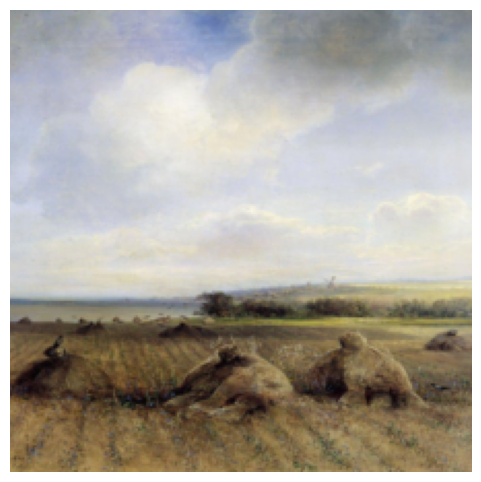

Ground Truth Caption: this painting has amazing detail in the grass and it has great depth
Emotion Label: contentment


In [4]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from preprocessing import get_loader, EMOTION_MAP # Import EMOTION_MAP directly

# --- 1. Configuration & Constants ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

IMAGE_FOLDER = "./wikiart/"   
CAPTIONS_FILE = "captions.csv" 
BATCH_SIZE = 32

# --- 2. Initialize Data Loaders ---
print("Initializing Vocabulary and DataLoader...")
train_loader, train_dataset = get_loader(
    root_folder=IMAGE_FOLDER,
    annotation_file=CAPTIONS_FILE,
    transform=transform,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(f"✅ Preprocessing Complete.")
print(f"Vocabulary Size: {len(train_dataset.vocab)} words")
print(f"Number of Batches: {len(train_loader)}")

# --- 3. Sanity Check (Verification) ---
images, captions, emotions = next(iter(train_loader)) 

print("\n--- Batch Verification ---")
print(f"Image Batch Shape: {images.shape}")    # Expected: [32, 3, 224, 224]
print(f"Caption Batch Shape: {captions.shape}")
print(f"Emotion Batch Shape: {emotions.shape}")

# --- 4. Visual Proof ---
def decode_caption(caption_indices, vocab):
    words = []
    for idx in caption_indices:
        word = vocab.itos[idx.item()]
        if word == "<start>": continue
        if word == "<end>": break
        words.append(word)
    return " ".join(words)

# Create the reverse map correctly using the imported dictionary
idx_to_emotion = {v: k for k, v in EMOTION_MAP.items()}

# Display the first image
plt.figure(figsize=(6, 6))
plt.imshow(images[0].permute(1, 2, 0))
plt.axis("off")
plt.show()

# Decode and print text
decoded_text = decode_caption(captions[0], train_dataset.vocab)
emotion_str = idx_to_emotion.get(emotions[0].item(), "Unknown")

print(f"Ground Truth Caption: {decoded_text}")
print(f"Emotion Label: {emotion_str}")

In [5]:
from preprocessing import create_tfidf_embeddings_from_scratch

# 1. Get the raw text from the dataset
# We need the list of strings, not the tensors
all_captions = train_dataset.captions 

# 2. Define embedding dimension (must match your future LSTM settings)
EMBED_DIM = 256 

# 3. Compute the matrix
print("--- Generating TF-IDF Embeddings ---")
tfidf_weights = create_tfidf_embeddings_from_scratch(
    captions=all_captions, 
    vocab=train_dataset.vocab, 
    embed_dim=EMBED_DIM
)

print(f"✅ TF-IDF Weights Ready. Shape: {tfidf_weights.shape}")
# Expected shape: (Vocab_Size, 256)

--- Generating TF-IDF Embeddings ---
Step 1: Computing Document Frequencies...
Step 2: Computing IDF...
Step 3: Creating Sparse TF-IDF Matrix...
Step 4: Dimensionality Reduction to 256...
✅ TF-IDF Weights Ready. Shape: torch.Size([1645, 256])


In [6]:
import torch.optim as optim
import time
import os

# Import your custom modules
# %load_ext autoreload
# %autoreload 2
from preprocessing import get_loader, create_tfidf_embeddings_from_scratch, load_pretrained_vectors
from model import CustomImageCaptionModel 

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Paths (Adjust these if your file names differ)
IMAGE_FOLDER = "./wikiart/"
CAPTIONS_FILE = "captions.csv"
GLOVE_PATH = "glove.6B.300d.txt"       # Ensure this file exists
FASTTEXT_PATH = "wiki-news-300d-1M.vec" # Ensure this file exists

Device: cpu


In [7]:
# Hyperparameters for Data Loading
BATCH_SIZE = 32
VOCAB_THRESHOLD = 5

from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

print("--- Loading Data ---")
train_loader, train_dataset = get_loader(
    root_folder=IMAGE_FOLDER,
    annotation_file=CAPTIONS_FILE,
    transform=transform,
    batch_size=BATCH_SIZE,
    shuffle=True
)

VOCAB_SIZE = len(train_dataset.vocab)
print(f"Vocabulary Size: {VOCAB_SIZE}")
print(f"Number of Batches: {len(train_loader)}")

--- Loading Data ---
Dataset too large (454684). Subsetting to 6000 samples for efficiency.
Vocabulary Size: 1645
Number of Batches: 188


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

def train_experiment(experiment_name, embedding_weights, embed_dim, num_epochs=5):
    print(f"\n\n{'='*20}")
    print(f"STARTING EXPERIMENT: {experiment_name}")
    print(f"{'='*20}")
    
    # 1. Initialize Model
    model = CustomImageCaptionModel(
        embed_size=embed_dim,
        hidden_size=256, 
        vocab_size=VOCAB_SIZE,
        embedding_weights=embedding_weights
    ).to(device)
    
    # 2. Loss and Optimizer
    pad_idx = train_dataset.vocab.stoi["<pad>"]
    
    # nn is now guaranteed to be defined
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 3. Training Loop
    model.train()
    loss_history = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0
        
        for batch_idx, (images, captions, emotions) in enumerate(train_loader):
            # Move to device
            images = images.to(device)
            captions = captions.to(device)
            emotions = emotions.to(device)
            
            # Prepare Targets
            inputs = captions[:, :-1]
            targets = captions[:, 1:]
            
            # Forward Pass
            outputs = model(images, inputs, emotions)
            
            # Calculate Loss
            loss = criterion(outputs.reshape(-1, VOCAB_SIZE), targets.reshape(-1))
            
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 50 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}], Loss: {loss.item():.4f}")
        
        # Epoch Stats
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        elapsed = time.time() - start_time
        print(f"✅ Epoch {epoch+1} Complete. Avg Loss: {avg_loss:.4f}. Time: {elapsed:.1f}s")
        
    # 4. Save Model
    save_path = f"model_{experiment_name}.pt"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")
    
    return loss_history

In [ ]:
from preprocessing import create_tfidf_embeddings_from_scratch, load_pretrained_vectors

# Configuration
NUM_EPOCHS = 15 
results = {}

# --- RUN 1: TF-IDF [cite: 51] ---
print("Generating TF-IDF Embeddings...")
tfidf_dim = 256
tfidf_weights = create_tfidf_embeddings_from_scratch(
    train_dataset.captions, 
    train_dataset.vocab, 
    embed_dim=tfidf_dim
)

results['TF-IDF'] = train_experiment(
    experiment_name="TF-IDF",
    embedding_weights=tfidf_weights,
    embed_dim=tfidf_dim,
    num_epochs=NUM_EPOCHS
)

# --- RUN 2: GloVe [cite: 57] ---
print("\nLoading GloVe Embeddings...")
glove_dim = 300
glove_weights = load_pretrained_vectors(
    train_dataset.vocab, 
    GLOVE_PATH, 
    embed_dim=glove_dim
)

results['GloVe'] = train_experiment(
    experiment_name="GloVe",
    embedding_weights=glove_weights,
    embed_dim=glove_dim,
    num_epochs=NUM_EPOCHS
)

# --- RUN 3: FastText [cite: 58] ---
print("\nLoading FastText Embeddings...")
fasttext_dim = 300
fasttext_weights = load_pretrained_vectors(
    train_dataset.vocab, 
    FASTTEXT_PATH, 
    embed_dim=fasttext_dim
)

results['FastText'] = train_experiment(
    experiment_name="FastText",
    embedding_weights=fasttext_weights,
    embed_dim=fasttext_dim,
    num_epochs=NUM_EPOCHS
)

Generating TF-IDF Embeddings...
Step 1: Computing Document Frequencies...
Step 2: Computing IDF...
Step 3: Creating Sparse TF-IDF Matrix...
Step 4: Dimensionality Reduction to 256...


STARTING EXPERIMENT: TF-IDF


/Users/ape/Documents/Ashoka/Monsoon 2025/Introduction to Machine Learning/Assignments/Assignment 3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/15], Step [0], Loss: 7.4149
Epoch [1/15], Step [50], Loss: 5.3890


/Users/ape/Documents/Ashoka/Monsoon 2025/Introduction to Machine Learning/Assignments/Assignment 3/venv/lib/python3.13/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/15], Step [100], Loss: 5.3463
Epoch [1/15], Step [150], Loss: 5.3497


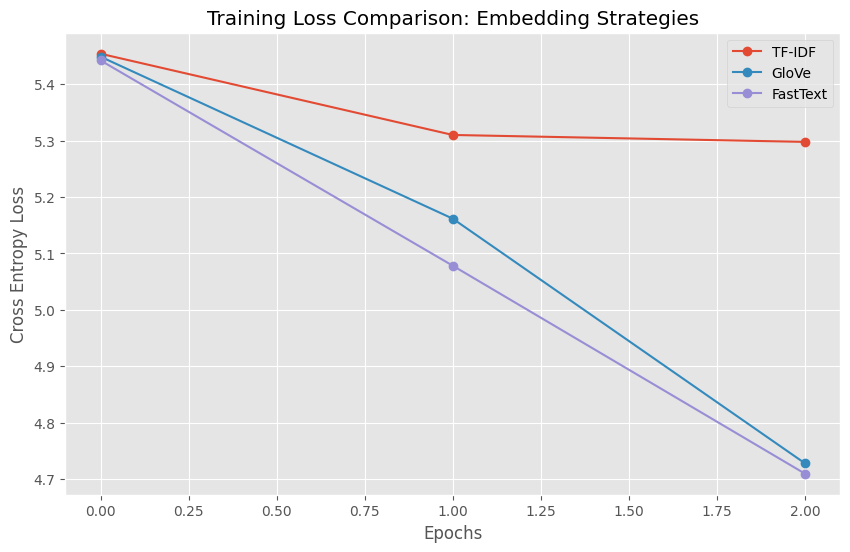

In [11]:

plt.figure(figsize=(10, 6))

for name, losses in results.items():
    plt.plot(losses, label=name, marker='o')

plt.title("Training Loss Comparison: Embedding Strategies")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import torch.nn.functional as F

def generate_caption(model, image, emotion_idx, dataset, max_len=20, temperature=0.8):
    """
    Generates a caption using Temperature Sampling to fix repetition loops.
    temperature: Lower (0.5) = More confident/repetitive. Higher (1.0) = More random/diverse.
    """
    model.eval()
    vocab = dataset.vocab
    
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        emotion = torch.tensor([emotion_idx]).to(device)
        
        img_features = model.forward_encoder(image)
        emo_features = model.emotion_embed(emotion)
        context = torch.cat((img_features, emo_features), dim=1)
        
        h = torch.zeros(1, model.lstm.hidden_size).to(device)
        c = torch.zeros(1, model.lstm.hidden_size).to(device)
        states = (h, c)
        
        start_token = vocab.stoi["<start>"]
        current_word_idx = torch.tensor([start_token]).to(device)
        
        captions_ids = []
        
        for _ in range(max_len):
            word_embed = model.embed(current_word_idx)
            lstm_input = torch.cat((context, word_embed), dim=1).unsqueeze(1)
            
            output, states = model.lstm(lstm_input, states)
            prediction = model.linear(output.squeeze(1)) # (1, Vocab_Size)
            
            # --- FIX: SAMPLING INSTEAD OF ARGMAX ---
            # 1. Apply Temperature (Sharpen/Flatten distribution)
            prediction = prediction / temperature
            
            # 2. Convert to Probabilities
            probs = F.softmax(prediction, dim=1)
            
            # 3. Sample from distribution
            predicted_id = torch.multinomial(probs, num_samples=1)
            # ---------------------------------------
            
            if predicted_id.item() == vocab.stoi["<end>"]:
                break
                
            captions_ids.append(predicted_id.item())
            current_word_idx = predicted_id.squeeze(0) # Update input
            
        return [vocab.itos[idx] for idx in captions_ids]

In [16]:
def calculate_bleu_score(model, loader, dataset, num_batches=5):
    """
    Calculates BLEU-1 score on a subset of the data.
    """
    model.eval()
    chencherry = SmoothingFunction()
    total_bleu = 0
    count = 0
    
    print(f"Calculating BLEU over {num_batches} batches...")
    
    with torch.no_grad():
        for batch_idx, (images, captions, emotions) in enumerate(loader):
            if batch_idx >= num_batches: break
            
            images = images.to(device)
            emotions = emotions.to(device)
            
            for i in range(len(images)):
                # Generate
                gen_words = generate_caption(model, images[i], emotions[i].item(), dataset)
                
                # Ground Truth (List of words)
                gt_ids = [idx.item() for idx in captions[i] if idx.item() not in [0, 1, 2]]
                gt_words = [dataset.vocab.itos[idx] for idx in gt_ids]
                
                # Calculate BLEU (Reference must be list of lists)
                score = sentence_bleu([gt_words], gen_words, smoothing_function=chencherry.method1)
                total_bleu += score
                count += 1
                
    avg_bleu = total_bleu / count
    print(f"Average BLEU Score: {avg_bleu:.4f}")
    return avg_bleu


TESTING MODEL: TF-IDF
Weights loaded successfully.


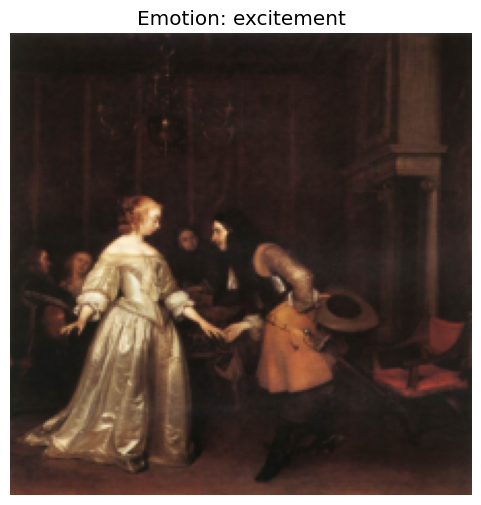

Ground Truth: this painting <unk> a lively <unk> setting
Generated:    always <unk> the <unk> lot in <unk> upset i
--------------------------------------------------


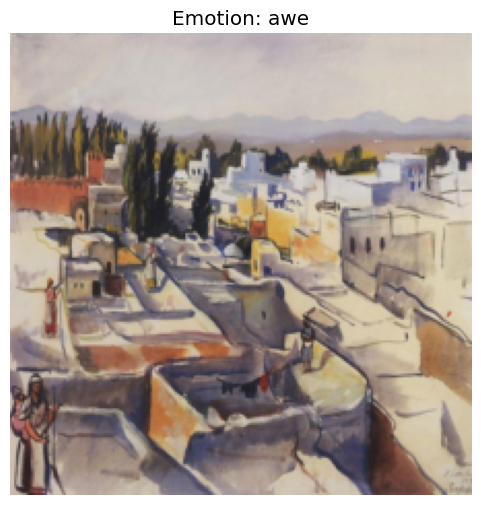

Ground Truth: <unk> <unk> i love the <unk> of the buildings
Generated:    
--------------------------------------------------
Calculating BLEU over 5 batches...
Average BLEU Score: 0.0105

TESTING MODEL: GloVe
Weights loaded successfully.


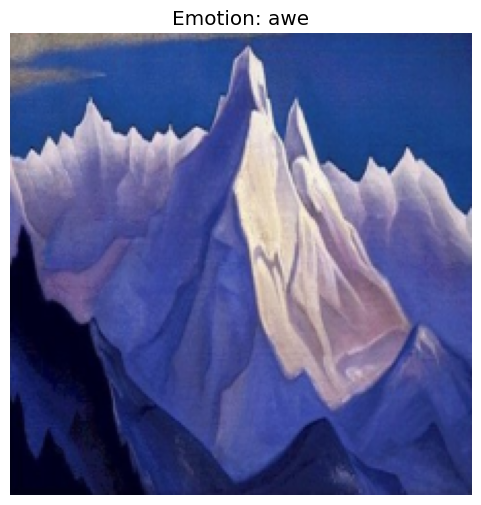

Ground Truth: these <unk> mountains and their deep blue shadows make me feel inspired
Generated:    of <unk>
--------------------------------------------------


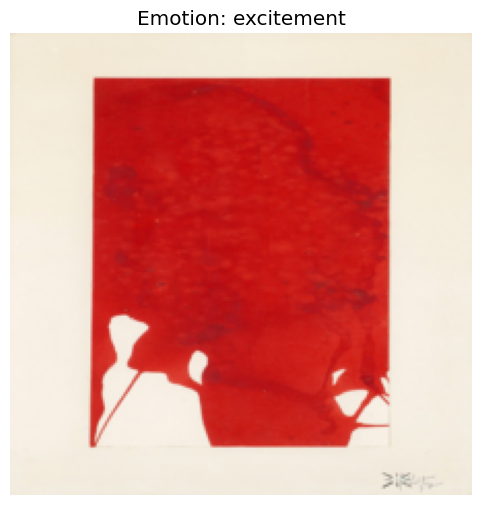

Ground Truth: i really like this one it is simple but it almost looks like someone turned marble into paint its very cool
Generated:    the figure reminds me feel would <unk> as great has a old <unk> maybe because there looks like a oddly
--------------------------------------------------
Calculating BLEU over 5 batches...
Average BLEU Score: 0.0196

TESTING MODEL: FastText
Weights loaded successfully.


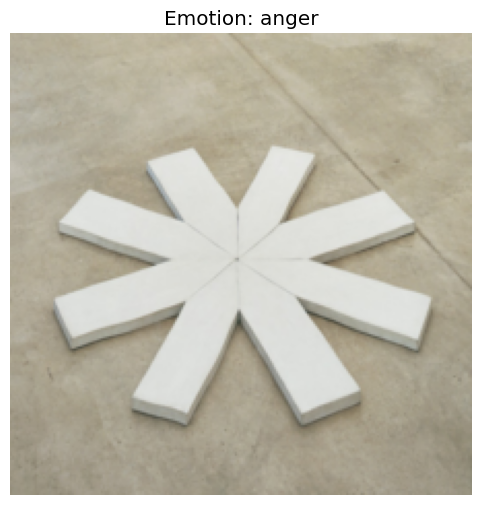

Ground Truth: thats not art i dont care what anyone says
Generated:    this face way me feel piece on it feel the viewer <unk> <unk>
--------------------------------------------------


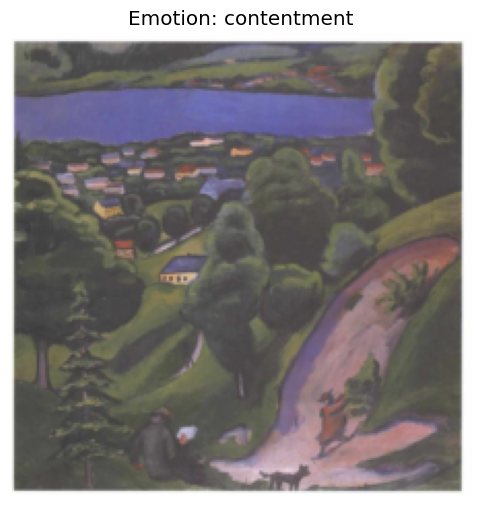

Ground Truth: nice <unk> view of a city from <unk> a <unk> colors
Generated:    the and a <unk> in the love make of of the <unk> of
--------------------------------------------------
Calculating BLEU over 5 batches...
Average BLEU Score: 0.0175


In [17]:
# Constants for reloading
VOCAB_SIZE = len(train_dataset.vocab)

# List of your experiments
saved_models = [
    ("TF-IDF", "model_TF-IDF.pt", 256),
    ("GloVe", "model_GloVe.pt", 300),
    ("FastText", "model_FastText.pt", 300)
]

for name, path, dim in saved_models:
    print(f"\n{'='*30}")
    print(f"TESTING MODEL: {name}")
    print(f"{'='*30}")
    
    # 1. Initialize empty model architecture
    model_test = CustomImageCaptionModel(
        embed_size=dim,
        hidden_size=256,
        vocab_size=VOCAB_SIZE,
        embedding_weights=None # We load weights from state_dict, so None is fine here
    ).to(device)
    
    # 2. Load the trained weights
    try:
        model_test.load_state_dict(torch.load(path, map_location=device))
        print("Weights loaded successfully.")
    except FileNotFoundError:
        print(f"Model file {path} not found. Skipping.")
        continue

    # 3. Qualitative: Show images
    evaluate_model_visual(model_test, train_loader, train_dataset, num_samples=2)
    
    # 4. Quantitative: BLEU Score
    calculate_bleu_score(model_test, train_loader, train_dataset, num_batches=5)